# Ensemble-based models to predict tissue

**Can we predict the tissue of origin of a sample from it's gene expression data?**

- AdaBoost - tends to overfit
- Bagging ensemble of ridge classifiers
- Hyperparameter sweeping for optimal performance

author: @emilyekstrum
<br> 12/11/25

In [1]:
# load in modules
import numpy as np
import pandas as pd
import gzip
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from itertools import product

# random seed 
np.random.seed(42)

In [2]:
# load latent spaces
latent_spaces = np.load('gtex_latent_spaces.npz')
pca_result_2d = latent_spaces['pca_2d']
pca_result_85 = latent_spaces['pca_hd']
umap_result_2d = latent_spaces['umap_from_2d']
umap_result_hd = latent_spaces['umap_from_hd']

print(f"Latent space shapes:")
print(f"PCA 2D: {pca_result_2d.shape}")
print(f"PCA high-D: {pca_result_85.shape}") # PCA that retained 85% variance
print(f"UMAP from 2D: {umap_result_2d.shape}")
print(f"UMAP from high-D: {umap_result_hd.shape}")

Latent space shapes:
PCA 2D: (12289, 2)
PCA high-D: (12289, 83)
UMAP from 2D: (12289, 2)
UMAP from high-D: (12289, 2)


In [3]:
# open merged dataframe to get tissue labels
with gzip.open('GTEx_merged_processed_data.csv.gz', 'rt') as f:
    merged_df = pd.read_csv(f)

# extract tissue labels
tissue_labels = merged_df['SMTS'].values
print(f"Number of samples: {len(tissue_labels)}")
print(f"Number of unique tissues: {len(np.unique(tissue_labels))}")
print(f"Tissue types: {np.unique(tissue_labels)}")

Number of samples: 12289
Number of unique tissues: 27
Tissue types: ['Adipose Tissue' 'Adrenal Gland' 'Blood' 'Blood Vessel' 'Brain' 'Breast'
 'Colon' 'Esophagus' 'Heart' 'Kidney' 'Liver' 'Lung' 'Muscle' 'Nerve'
 'Ovary' 'Pancreas' 'Pituitary' 'Prostate' 'Salivary Gland' 'Skin'
 'Small Intestine' 'Spleen' 'Stomach' 'Testis' 'Thyroid' 'Uterus' 'Vagina']


/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_25036/4003594004.py:3: DtypeWarning: Columns (5008) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv(f)


### Hyperparameter sweep

Tests different parameters for:
1. AdaBoost: n_estimators, learning_rate, base estimator parameters
2. Bagging Ridge: n_estimators, ridge alpha, max_samples, max_features

In [4]:
# dictionary of latent spaces
latent_spaces_dict = {
    'PCA_2D': pca_result_2d,
    'PCA_HighD': pca_result_85,
    'UMAP_from_2D': umap_result_2d,
    'UMAP_from_HighD': umap_result_hd
}

print("Latent spaces for hyperparameter sweeping:")
for name, data in latent_spaces_dict.items():
    print(f"  {name}: {data.shape}")

Latent spaces for hyperparameter sweeping:
  PCA_2D: (12289, 2)
  PCA_HighD: (12289, 83)
  UMAP_from_2D: (12289, 2)
  UMAP_from_HighD: (12289, 2)


In [5]:
#  hyperparameter sweep function
def hyperparameter_sweep(X_data, y_data, space_name, n_jobs=-1):
    """
    hyperparameter sweeping for ensemble methods
    """
    print(f"\nHyperparameter sweep for {space_name}")
    
    # split data 
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
    )
    
    # split training data for validation
    X_train_inner, X_val, y_train_inner, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    results = {}
    
    # 1. AdaBoost hyperparameter sweep
    print("\n1. AdaBoost Hyperparameter Sweep")
    adaboost_params = {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.1, 0.5, 1.0, 1.5, 2.0],
    }
    
    best_ada_score = 0
    best_ada_params = None
    ada_results = []
    
    total_combinations = len(list(product(*adaboost_params.values())))
    current_combo = 0
    
    for n_est in adaboost_params['n_estimators']:
        for lr in adaboost_params['learning_rate']:
                current_combo += 1
                try:
                    ada_model = AdaBoostClassifier(
                        n_estimators=n_est,
                        learning_rate=lr,
                        random_state=42
                    )
                    
                    ada_model.fit(X_train_inner, y_train_inner)
                    val_score = ada_model.score(X_val, y_val)
                    
                    ada_results.append({
                        'n_estimators': n_est,
                        'learning_rate': lr,
                        'val_score': val_score
                    })
                    
                    if val_score > best_ada_score:
                        best_ada_score = val_score
                        best_ada_params = {'n_estimators': n_est, 'learning_rate': lr}
                    
                    if current_combo % 10 == 0:
                        print(f"  Progress: {current_combo}/{total_combinations} - Best so far: {best_ada_score:.4f}")
                        
                except Exception as e:
                    print(f"  Error with params {n_est}, {lr}: {e}")
    
    print(f"  Best AdaBoost params: {best_ada_params} (Score: {best_ada_score:.4f})")
    
    # 2. Bagging Ridge hyperparameter sweep
    print("\n2. Bagging ridge hyperparameter sweep")
    bagging_params = {
        'n_estimators': [25, 50, 100, 150],
        'ridge_alpha': [0.1, 1.0, 10.0, 100.0],
        'max_samples': [0.7, 0.8, 0.9, 1.0],
        'max_features': [0.7, 0.8, 0.9, 1.0]
    }
    
    best_bag_score = 0
    best_bag_params = None
    bag_results = []
    
    current_combo = 0
    total_combinations = len(list(product(*bagging_params.values())))
    
    for n_est in bagging_params['n_estimators']:
        for alpha in bagging_params['ridge_alpha']:
            for max_samp in bagging_params['max_samples']:
                for max_feat in bagging_params['max_features']:
                    current_combo += 1
                    try:
                        bag_model = BaggingClassifier(
                            estimator=RidgeClassifier(alpha=alpha),
                            n_estimators=n_est,
                            max_samples=max_samp,
                            max_features=max_feat,
                            random_state=42,
                            n_jobs=1  
                        )
                        
                        bag_model.fit(X_train_inner, y_train_inner)
                        val_score = bag_model.score(X_val, y_val)
                        
                        bag_results.append({
                            'n_estimators': n_est,
                            'ridge_alpha': alpha,
                            'max_samples': max_samp,
                            'max_features': max_feat,
                            'val_score': val_score
                        })
                        
                        if val_score > best_bag_score:
                            best_bag_score = val_score
                            best_bag_params = {
                                'n_estimators': n_est,
                                'ridge_alpha': alpha,
                                'max_samples': max_samp,
                                'max_features': max_feat
                            }
                        
                        if current_combo % 20 == 0:
                            print(f"  Progress: {current_combo}/{total_combinations} - Best so far: {best_bag_score:.4f}")
                            
                    except Exception as e:
                        print(f"  Error with params: {e}")
    
    print(f"  Best Bagging Ridge params: {best_bag_params} (Score: {best_bag_score:.4f})")
    
    
    # train best models on full training set and evaluate on test set
    print("\n4. Evaluation on test set")
    final_results = {}
    
    # Best AdaBoost
    if best_ada_params:
        final_ada = AdaBoostClassifier(**best_ada_params, random_state=42)
        final_ada.fit(X_train, y_train)
        ada_test_score = final_ada.score(X_test, y_test)
        final_results['AdaBoost'] = {
            'model': final_ada,
            'params': best_ada_params,
            'test_score': ada_test_score,
            'predictions': final_ada.predict(X_test)
        }
        print(f"  AdaBoost test accuracy: {ada_test_score:.4f}")
    
    # Best bagging ridge
    if best_bag_params:
        ridge_alpha = best_bag_params.pop('ridge_alpha')
        final_bag = BaggingClassifier(
            estimator=RidgeClassifier(alpha=ridge_alpha),
            **best_bag_params,
            random_state=42,
            n_jobs=n_jobs
        )
        final_bag.fit(X_train, y_train)
        bag_test_score = final_bag.score(X_test, y_test)
        final_results['Bagging_Ridge'] = {
            'model': final_bag,
            'params': {**best_bag_params, 'ridge_alpha': ridge_alpha},
            'test_score': bag_test_score,
            'predictions': final_bag.predict(X_test)
        }
        print(f"  Bagging Ridge test accuracy: {bag_test_score:.4f}")
    

    # results
    results[space_name] = {
        'final_models': final_results,
        'y_test': y_test,
        'adaboost_sweep': ada_results,
        'bagging_sweep': bag_results,
        'best_overall': max(final_results.items(), key=lambda x: x[1]['test_score'])
    }
    
    print(f"Best overall model: {results[space_name]['best_overall'][0]} (Accuracy: {results[space_name]['best_overall'][1]['test_score']:.4f})")
    
    return results[space_name]

In [6]:
# perform hyperparameter sweeping on all latent spaces

# run hyperparameter sweep for each latent space
sweep_results = {}

for space_name, X_data in latent_spaces_dict.items():
    sweep_results[space_name] = hyperparameter_sweep(X_data, tissue_labels, space_name)


Hyperparameter sweep for PCA_2D

1. AdaBoost Hyperparameter Sweep
  Progress: 10/20 - Best so far: 0.4179
  Progress: 20/20 - Best so far: 0.4509
  Best AdaBoost params: {'n_estimators': 300, 'learning_rate': 1.0} (Score: 0.4509)

2. Bagging ridge hyperparameter sweep
  Progress: 20/256 - Best so far: 0.3528
  Progress: 40/256 - Best so far: 0.3528
  Progress: 60/256 - Best so far: 0.3528
  Progress: 80/256 - Best so far: 0.3533
  Progress: 100/256 - Best so far: 0.3533
  Progress: 120/256 - Best so far: 0.3533
  Progress: 140/256 - Best so far: 0.3533
  Progress: 160/256 - Best so far: 0.3533
  Progress: 180/256 - Best so far: 0.3533
  Progress: 200/256 - Best so far: 0.3533
  Progress: 220/256 - Best so far: 0.3533
  Progress: 240/256 - Best so far: 0.3533
  Best Bagging Ridge params: {'n_estimators': 50, 'ridge_alpha': 0.1, 'max_samples': 0.8, 'max_features': 1.0} (Score: 0.3533)

4. Evaluation on test set
  AdaBoost test accuracy: 0.4650
  Bagging Ridge test accuracy: 0.3617
Best 

In [7]:
# results analysis
print("\nResults")

# compile all results
all_results = []
for space_name, space_results in sweep_results.items():
    for model_name, model_results in space_results['final_models'].items():
        all_results.append({
            'latent_space': space_name,
            'model': model_name,
            'test_accuracy': model_results['test_score'],
            'parameters': model_results['params']
        })

# create results dataframe
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('test_accuracy', ascending=False)

print("\nTop 10 Models:")
print(results_df.head(10).to_string(index=False))

# best model overall
best_config = results_df.iloc[0]
print(f"\nBest Model:")
print(f"Latent Space: {best_config['latent_space']}")
print(f"Model: {best_config['model']}")
print(f"Test Accuracy: {best_config['test_accuracy']:.4f}")
print(f"Parameters: {best_config['parameters']}")


Results

Top 10 Models:
   latent_space         model  test_accuracy                                                                          parameters
      PCA_HighD Bagging_Ridge       0.963792   {'n_estimators': 25, 'max_samples': 0.7, 'max_features': 1.0, 'ridge_alpha': 0.1}
      PCA_HighD      AdaBoost       0.776241                                         {'n_estimators': 300, 'learning_rate': 2.0}
UMAP_from_HighD      AdaBoost       0.647681                                         {'n_estimators': 300, 'learning_rate': 1.0}
         PCA_2D      AdaBoost       0.465012                                         {'n_estimators': 300, 'learning_rate': 1.0}
   UMAP_from_2D      AdaBoost       0.432059                                         {'n_estimators': 300, 'learning_rate': 0.5}
UMAP_from_HighD Bagging_Ridge       0.412124  {'n_estimators': 100, 'max_samples': 0.7, 'max_features': 1.0, 'ridge_alpha': 0.1}
         PCA_2D Bagging_Ridge       0.361676   {'n_estimators': 50, 'max


Best model analysis:
Configuration: Bagging_Ridge on PCA_HighD
Test Accuracy: 0.9638
Optimal Parameters: {'n_estimators': 25, 'max_samples': 0.7, 'max_features': 1.0, 'ridge_alpha': 0.1}

Classification Report:
                 precision    recall  f1-score   support

 Adipose Tissue       0.82      1.00      0.90       177
  Adrenal Gland       1.00      1.00      1.00        33
          Blood       1.00      1.00      1.00       116
   Blood Vessel       0.99      0.98      0.98       178
          Brain       0.99      1.00      1.00       422
         Breast       0.97      0.50      0.66        66
          Colon       0.90      0.97      0.93       114
      Esophagus       0.92      0.99      0.96       199
          Heart       0.99      0.97      0.98       125
         Kidney       1.00      1.00      1.00        13
          Liver       1.00      1.00      1.00        32
           Lung       1.00      1.00      1.00        77
         Muscle       0.98      1.00      0.99

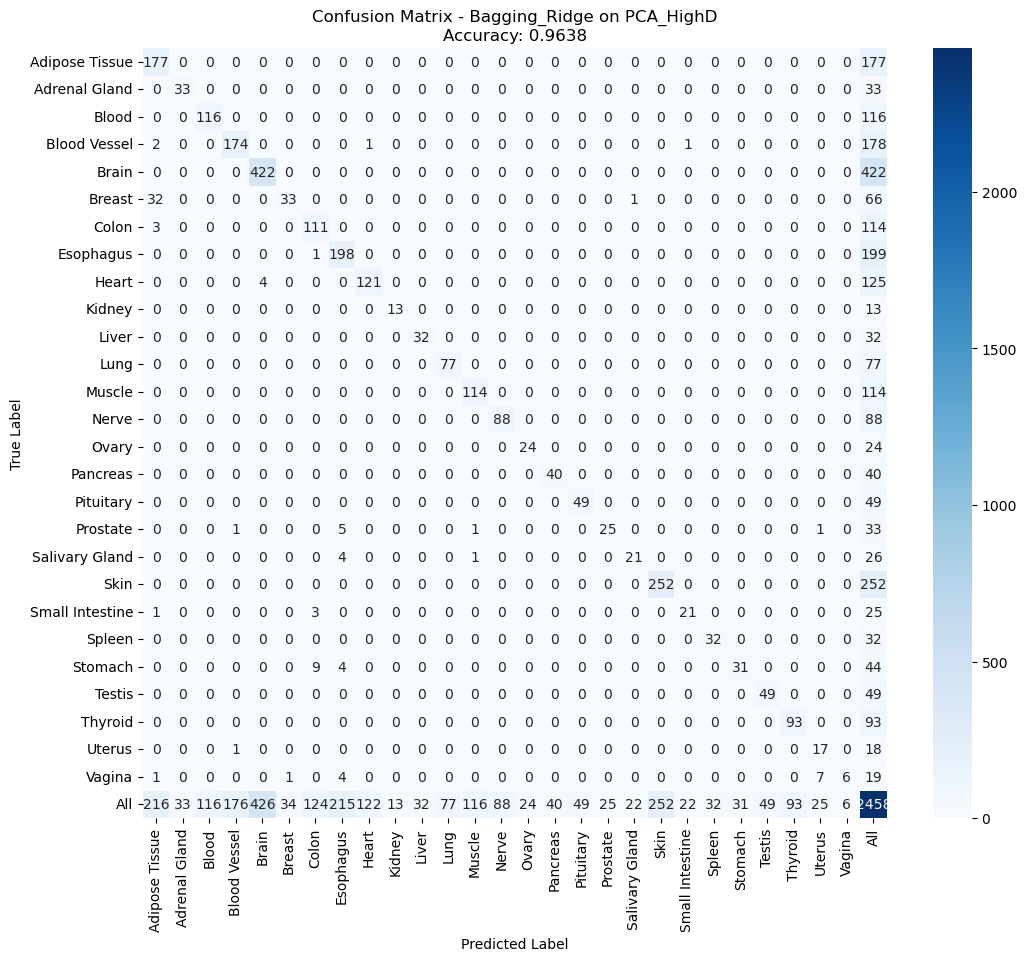

In [8]:
# analysis of best model
best_space = best_config['latent_space']
best_model_name = best_config['model']
best_model_data = sweep_results[best_space]['final_models'][best_model_name]

print(f"\nBest model analysis:")
print(f"Configuration: {best_model_name} on {best_space}")
print(f"Test Accuracy: {best_model_data['test_score']:.4f}")
print(f"Optimal Parameters: {best_model_data['params']}")

# classification report for best model
y_test_best = sweep_results[best_space]['y_test']
y_pred_best = best_model_data['predictions']

print("\nClassification Report:")
print(classification_report(y_test_best, y_pred_best))

# confusion matrix for best model
plt.figure(figsize=(12, 10))
cm = pd.crosstab(y_test_best, y_pred_best, margins=True)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name} on {best_space}\nAccuracy: {best_model_data["test_score"]:.4f}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()